# Project 2 - Randomized Trials in Economics
### Alexander Jeremijenko - Econ 123

In [465]:
import pandas as pd
import matplotlib as plt
import statsmodels.api as sm
import numpy as np
import scipy.stats as st
from scipy.stats import ttest_ind as ttest
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
from scipy.stats import f as f_test
from scipy.stats import tstd
warnings.simplefilter('ignore', ValueWarning)

In [466]:
df = pd.read_stata('AEJApp-20090168_data.dta')
print('Field names are:')
display(pd.DataFrame(df.columns).rename(columns = {0: 'column'}))
display(df)

Field names are:


,column
0,age_s
1,dmarried_s
2,empl_06
3,salary_06
4,profit_06
5,tenure_06
6,days_06
7,hours_06
8,contract_06
9,dformal_06


,age_s,dmarried_s,empl_06,salary_06,profit_06,tenure_06,days_06,hours_06,contract_06,dformal_06,...,pempl_06,pempl_04,dcontinue,codigo_ecap,codigo_curs,dwomen,p_selecap,formalsal_06,informalsal_06,coursefixe
0,22.0,0.0,1.0,0.0,240000.0,15.233334,22.0,84.0,0.0,0.0,...,0.0,0.0,1.0,1,63520505,0.0,0.666667,0.0,0.0,2.0
1,22.0,0.0,1.0,116000.0,0.0,1.866667,10.0,14.0,0.0,0.0,...,1.0,1.0,1.0,1,66120005,0.0,0.666667,0.0,116000.0,3.0
2,24.0,0.0,1.0,650000.0,0.0,1.866667,28.0,91.0,0.0,0.0,...,1.0,1.0,1.0,1,66120005,0.0,0.666667,0.0,650000.0,3.0
3,24.0,0.0,1.0,408000.0,0.0,0.100000,28.0,48.0,0.0,0.0,...,1.0,0.0,1.0,1,33110020,1.0,0.666667,0.0,408000.0,1.0
4,22.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1,63520505,0.0,0.666667,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,94,63220250,0.0,NaN,NaN,NaN,348.0
3952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,62,13530010,1.0,NaN,NaN,NaN,209.0
3953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,108,13420005,0.0,NaN,NaN,NaN,416.0
3954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,46,13110005,0.0,NaN,NaN,NaN,148.0


## Question 1
The power of the experiment is defined by the proportions sampled (1/2, 1/2) and the number of people in them, not the size of the population that they were sampled from. Sample size is a determinant of standard error of our estimates. 

## Question 2

In [467]:
df = pd.read_stata('AEJApp-20090168_data.dta')
# First remove people who did not continue in the sample
df = df[df['dcontinue'] == 1]
df = df.assign(select = lambda x: pd.to_numeric(x.select.map({'selected': 1, 'control': 0})))

dummies = pd.get_dummies(df.coursefixe, prefix = 'fe')
dummy_list = list(dummies.columns)
# Remove the last item from the dummies
dummy_list.pop()
df = pd.concat([df, dummies], axis = 1).drop('coursefixe', axis = 1)

# Next split into men and women
df_w = df[df['dwomen'] == 1]
df_m = df[df['dwomen'] == 0]

# Now split into control (c) and treatment (t), also grouped by male and female
df_w_t = df_w[df_w.select == 1]
df_w_c = df_w[df_w.select == 0]
df_m_t = df_m[df_m.select == 1]
df_m_c = df_m[df_m.select == 0]


# Now, conducting t-tests at 5%, with the Null that the difference in means is 0, and the alternative being a difference greater than 0. The variables below were chosen because
# they are those which were chosen in the paper that we are replicating. Further, they all plausibly will effect future labor outcomes, since they are related to current labor
# conditions
variables = ['empl_04', 'contract_04', 'dformal_04', 'pempl_04', 'salary_04', 'profit_04', 'days_04', 'hours_04', 'age_lb', 'dmarried_lb']
genders = ['MALE', 'FEMALE']
ttest_df = pd.DataFrame(columns = ['gender', 'field_name', 't_val', 'percentage_diff', 'significance', 'indicator'])
for gender in genders:
    for variable in variables:
        if gender == 'MALE':
            t_val, sig_level = ttest(df_m_t[variable], df_m_c[variable])
            pct_diff = (df_m_t[variable].mean() - df_m_c[variable].mean())/df_m_t[variable].mean()*100
        else:
            t_val, sig_level = ttest(df_w_t[variable], df_w_c[variable])
            pct_diff = (df_w_t[variable].mean() - df_w_c[variable].mean())/df_w_t[variable].mean()*100
        significance = 'significant' if sig_level < 0.05 else 'unsignificant'
        new_data = {'gender': gender, 'field_name': variable, 't_val': t_val, 'percentage_diff': pct_diff, 'significance': sig_level, 'indicator': significance}
        ttest_df = ttest_df.append(new_data, ignore_index='True')
ttest_df

,gender,field_name,t_val,percentage_diff,significance,indicator
0,MALE,empl_04,2.515859,10.732105,0.011980,significant
1,MALE,contract_04,0.081946,1.256891,0.934701,unsignificant
2,MALE,dformal_04,-0.075694,-1.087616,0.939673,unsignificant
3,MALE,pempl_04,3.501277,20.473390,0.000477,significant
4,MALE,salary_04,1.377236,9.650209,0.168649,unsignificant
5,MALE,profit_04,-1.830769,-34.155462,0.067338,unsignificant
6,MALE,days_04,1.984302,9.087635,0.047408,significant
7,MALE,hours_04,2.080990,10.277980,0.037608,significant
8,MALE,age_lb,-1.435012,-0.731849,0.151497,unsignificant
9,MALE,dmarried_lb,-2.242761,-40.836707,0.025061,significant


We have no statistically significant fields for females, but several for males. Here, conducting a further joint F-test to see if these difference are jointly significant. 

In [468]:
y = df_w.select
X = sm.add_constant(df_w[variables])
f_value = sm.OLS(y, X.astype(float)).fit().fvalue
print('The f_test for women is:', f_value)

y = df_m.select
X = sm.add_constant(df_m[variables])
f_value = sm.OLS(y, X.astype(float)).fit().fvalue
print('The f_test for men is:', f_value)

The f_test for women is: 1.117445685509792
The f_test for men is: 3.480850005495692


We have a significant f statistic for men and an unsignificant one for women. This is in-line with the results of the paper and with the table above.

Before we begin the regression analysis, a check for heteroskedasticity. The check will be made by seeing if there is statistically significant covariance between the squared residuals of the OLS regression and the X independents. 

In [469]:
# First make predictions for y (we use employment as y here, and the characteristics above as X)
variables = dummy_list + ['select', 'empl_04', 'pempl_04', 'contract_04', 'dformal_04', 'salary_04', 'profit_04', 'tenure_04', 'days_04', 'hours_04', 'educ_lb', 'age_lb', 'dmarried_lb']
target = 'empl_06'

data = df[[target]+variables].dropna()
y = data[target]
X = sm.add_constant(data[variables])
model_1 = sm.OLS(y, X).fit()
predict = model_1.predict(X)
# Generate the residuals
residuals_sq = np.square((predict - y).values)
# Regress X and e
model_summary = sm.OLS(residuals_sq, X).fit()
model_summary = model.summary().as_text().split('\n')
# removing dummies
for li in model_summary:
    if li.startswith('Notes'):
        break  
    if not li.startswith('fe'):
        print(li)

                            OLS Regression Results                            
Dep. Variable:             dformal_06   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     37.42
Date:                Fri, 04 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:15:11   Log-Likelihood:                -616.50
No. Observations:                1669   AIC:                             2075.
Df Residuals:                    1248   BIC:                             4357.
Df Model:                         420                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1181      0.161     -0.734      

As we are seeing statistically significant correlations between the residuals and the X values (for example on select, and salary_04), we will be using heteroskedastic robust standard errors. 

## Question 3
Here we estimate the treatment effect on employment and earnings for men and women. The exogenous variables are our treatment dummy and the baseline characteristics that we included above.

In [470]:
variables = dummy_list + ['select', 'empl_04', 'pempl_04', 'contract_04', 'dformal_04', 'salary_04', 'profit_04', 'tenure_04', 'days_04', 'hours_04', 'educ_lb', 'age_lb', 'dmarried_lb']
target = 'empl_06'
for gender in genders:
    if gender == "MALE":
        data = df_m[[target]+variables].dropna()
        y = data[target]
        X = sm.add_constant(data[variables])
    else:
        data = df_w[[target]+variables].dropna()
        y = data[target]
        X = sm.add_constant(data[variables])
    print(f'***{gender}***')
    model = sm.OLS(y, X).fit(cov_type = 'HC3')
    model_summary = model.summary().as_text().split('\n')
    # removing dummies
    for li in model_summary:
        if li.startswith('Notes'):
            break  
        if not li.startswith('fe'):
            print(li) 


***MALE***
                            OLS Regression Results                            
Dep. Variable:                empl_06   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     16.46
Date:                Fri, 04 Dec 2020   Prob (F-statistic):          1.65e-258
Time:                        22:15:11   Log-Likelihood:                -322.31
No. Observations:                1329   AIC:                             1437.
Df Residuals:                     933   BIC:                             3493.
Df Model:                         395                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2419      0.346      

The treatment effect for women is 0.0629 (~6.3%), and is statistically significant (t-value = 2.737). For men we do not get a statistically significant effect, and the coefficient obtained is slightly negative (but near 0 (-0.015)). 

### For Salary

In [471]:
variables = dummy_list + ['select', 'empl_04', 'pempl_04', 'contract_04', 'dformal_04', 'salary_04', 'profit_04', 'tenure_04', 'days_04', 'hours_04', 'educ_lb', 'age_lb', 'dmarried_lb']
target = 'salary_06'
for gender in genders:
    if gender == "MALE":
        data = df_m[[target]+variables].dropna()
        y = data[target]
        X = sm.add_constant(data[variables])
    else:
        data = df_w[[target]+variables].dropna()
        y = data[target]
        X = sm.add_constant(data[variables])
    print(f'***{gender}***')
    model = sm.OLS(y, X).fit(cov_type = 'HC3')
    model_summary = model.summary().as_text().split('\n')
    # removing dummies
    for li in model_summary:
        if li.startswith('Notes'):
            break  
        if not li.startswith('fe'):
            print(li) 

***MALE***
                            OLS Regression Results                            
Dep. Variable:              salary_06   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     24.99
Date:                Fri, 04 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:15:13   Log-Likelihood:                -17938.
No. Observations:                1329   AIC:                         3.667e+04
Df Residuals:                     933   BIC:                         3.872e+04
Df Model:                         395                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.501e+04   1.74e+05      

Here we have statistically significant and positive effects of treatment women (31750 +04, t = 2.725), and an unsignificant, but positive coefficient for men (18140, t = 1.129)

## Overall

In [472]:
variables = dummy_list + ['select', 'empl_04', 'pempl_04', 'contract_04', 'dformal_04', 'salary_04', 'profit_04', 'tenure_04', 'days_04', 'hours_04', 'educ_lb', 'age_lb', 'dmarried_lb']
target = 'salary_06'
data = df[[target]+variables].dropna()
y = data[target]
X = sm.add_constant(data[variables])
model = sm.OLS(y, X).fit(cov_type = 'HC3')
model_summary = model.summary().as_text().split('\n')
# removing dummies
for li in model_summary:
    if li.startswith('Notes'):
        break  
    if not li.startswith('fe'):
        print(li)


                            OLS Regression Results                            
Dep. Variable:              salary_06   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     8.525
Date:                Fri, 04 Dec 2020   Prob (F-statistic):          4.70e-285
Time:                        22:15:14   Log-Likelihood:                -40617.
No. Observations:                2998   AIC:                         8.214e+04
Df Residuals:                    2546   BIC:                         8.485e+04
Df Model:                         451                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.315e+04   1.18e+05      0.196      

Overall we have a positive and significant effect of treatment (32680 at t = 3.780). 

To test whether the impact is the same for men and women we will use the original dataframe, incorporating the female dummy, and interacting the select and female dummy variables. Then we perform a t-test on the coefficient dwomen*select. 

In [473]:
# Create the ineraction
df = df.assign(select_w = lambda x: x.select * x.dwomen)

# For employment
variables = dummy_list + ['select_w', 'select', 'dwomen', 'empl_04', 'pempl_04', 'contract_04', 'dformal_04', 'salary_04', 'profit_04', 'tenure_04', 'days_04', 'hours_04', 'educ_lb', 'age_lb', 'dmarried_lb']
target = 'empl_06'
data = df[[target]+variables].dropna()
y = data[target]
X = sm.add_constant(data[variables])
model = sm.OLS(y, X).fit(cov_type = 'HC3')
model_summary = model.summary().as_text().split('\n')
# removing dummies
for li in model_summary:
    if li.startswith('Notes'):
        break  
    if not li.startswith('fe'):
        print(li)

                            OLS Regression Results                            
Dep. Variable:                empl_06   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     24.46
Date:                Fri, 04 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:15:15   Log-Likelihood:                -1369.2
No. Observations:                2998   AIC:                             3646.
Df Residuals:                    2544   BIC:                             6373.
Df Model:                         453                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1673      0.246      0.679      

We have a positive, significant value on select_w, our interacted variable (0.0771, 2.177). This is consistent with the result that we have uncovered above, namely, that women have larger employment benefits from treatment then men do. Further, there is similarly no strong evidence here to say that men have employment benefits from participating in the program at all.  

In [474]:
# For wages
variables = dummy_list + ['select_w', 'select', 'dwomen', 'empl_04', 'pempl_04', 'contract_04', 'dformal_04', 'salary_04', 'profit_04', 'tenure_04', 'days_04', 'hours_04', 'educ_lb', 'age_lb', 'dmarried_lb']
target = 'salary_06'
data = df[[target]+variables].dropna()
y = data[target]
X = sm.add_constant(data[variables])
model = sm.OLS(y, X).fit(cov_type = 'HC3')
model_summary = model.summary().as_text().split('\n')
# removing dummies
for li in model_summary:
    if li.startswith('Notes'):
        break  
    if not li.startswith('fe'):
        print(li)

                            OLS Regression Results                            
Dep. Variable:              salary_06   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     6.909
Date:                Fri, 04 Dec 2020   Prob (F-statistic):          2.13e-227
Time:                        22:15:16   Log-Likelihood:                -40581.
No. Observations:                2998   AIC:                         8.207e+04
Df Residuals:                    2544   BIC:                         8.480e+04
Df Model:                         453                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.484e+04   1.12e+05      0.311      

Here we uncover a positive but insignificant relationship between the dummy select_w and salary outcomes. This implies that we cannot say with a high degree of certainty that the female treated cohort differs in a material way from the male cohort in terms of salary benefits. What this regression is showing is that both cohorts have a positive salary benefit from participating in the program. 

## Part 5. Testing whether treatment effects are the same with and without accounting for fixed effects. 
#### using the following z-test:<br>
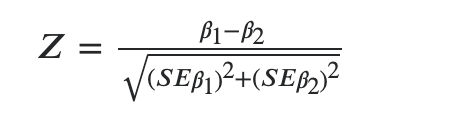

First testing with salary as our target


In [475]:
# Using salary as our target, first with fixed effects (dummy_list)
variables = dummy_list + ['select', 'empl_04', 'pempl_04', 'contract_04', 'dformal_04', 'salary_04', 'profit_04', 'tenure_04', 'days_04', 'hours_04', 'educ_lb', 'age_lb', 'dmarried_lb']
target = 'salary_06'
data = df[[target]+variables].dropna()
y = data[target]
X = sm.add_constant(data[variables])
model = sm.OLS(y, X).fit(cov_type = 'HC3')
unrestricted_coef = model.params['select']
unrestricted_stderr = model.bse['select']

# Now removing the fixed effect
variables = ['select', 'empl_04', 'pempl_04', 'contract_04', 'dformal_04', 'salary_04', 'profit_04', 'tenure_04', 'days_04', 'hours_04', 'educ_lb', 'age_lb', 'dmarried_lb']
target = 'salary_06'
data = df[[target]+variables].dropna()
y = data[target]
X = sm.add_constant(data[variables])
model = sm.OLS(y, X).fit(cov_type = 'HC3')
restricted_coef = model.params['select']
restricted_stderr = model.bse['select']

print(f"unrestricted coef and stderr: \ncoef: {unrestricted_coef}, stderr: {unrestricted_stderr}" )
print(f"restricted coef and stderr: \ncoef: {restricted_coef}, stderr: {restricted_stderr}" )

Z = (restricted_coef - unrestricted_coef)/(unrestricted_stderr**2 + unrestricted_stderr**2)**1/2
print("Z-Score =", Z)

unrestricted coef and stderr: 
coef: 32682.6076388949, stderr: 8646.137896047987
restricted coef and stderr: 
coef: 35797.529520567245, stderr: 7592.122734255852
Z-Score = 1.0417004523100241e-05


Using salary as our target, we find no evidence at all that including or discluding fixed effects impacts the results of the treatment effect. This implies that the dummies are likely uncorrelated with the effect of treatment on salary. <br>
Testing again with employment as our target. 

In [476]:
# Using employment as our target, first with fixed effects (dummy_list)
variables = dummy_list + ['select', 'empl_04', 'pempl_04', 'contract_04', 'dformal_04', 'salary_04', 'profit_04', 'tenure_04', 'days_04', 'hours_04', 'educ_lb', 'age_lb', 'dmarried_lb']
target = 'empl_06'
data = df[[target]+variables].dropna()
y = data[target]
X = sm.add_constant(data[variables])
model = sm.OLS(y, X).fit(cov_type = 'HC3')
unrestricted_coef = model.params['select']
unrestricted_stderr = model.bse['select']

# Now removing the fixed effect
variables = ['select', 'empl_04', 'pempl_04', 'contract_04', 'dformal_04', 'salary_04', 'profit_04', 'tenure_04', 'days_04', 'hours_04', 'educ_lb', 'age_lb', 'dmarried_lb']
target = 'empl_06'
data = df[[target]+variables].dropna()
y = data[target]
X = sm.add_constant(data[variables])
model = sm.OLS(y, X).fit(cov_type = 'HC3')
restricted_coef = model.params['select']
restricted_stderr = model.bse['select']

print(f"unrestricted coef and stderr: \ncoef: {unrestricted_coef}, stderr: {unrestricted_stderr}" )
print(f"restricted coef and stderr: \ncoef: {restricted_coef}, stderr: {restricted_stderr}" )

Z = (restricted_coef - unrestricted_coef)/(unrestricted_stderr**2 + unrestricted_stderr**2)**1/2
print("Z-Score =", Z)

unrestricted coef and stderr: 
coef: 0.02987637883618876, stderr: 0.018316547201872577
restricted coef and stderr: 
coef: 0.032936753972035465, stderr: 0.0160475480423568
Z-Score = 2.28048623179176


Here we find a statistically significant score (Z = 2.28). This implies that the dummies are quite probably correlated with the treatment effect in effecting employment outcomes. There are two potential reasons behind this. <br>
First, to enter the pool of people who would be randomly chosen from, each course had a different acceptance rate. Thus, it is possible that variance between the classes where introduced at this pre-randomization faze.<br>
Second, it is very plausible that there would be difference in outcomes based on the classes that each individual has taken. Perhaps, for example, taking a marketing course resulted in a higher improvement in employability then a hairdressing course. <br>
Overall, it seems like a rational idea to keep the fixed effects incorporated in the regression. 

## Question 6

As stated above, the fixed effects are designed to capture both the impact of variable selectivity between courses, as well as the different outcomes which might be associated with taking different courses. 

In [478]:
# using a F-Test to see if the fixed effects have an impact, using employment as our target.
# Resricted model
# Using employment as our target, first with fixed effects (dummy_list)
variables = dummy_list + ['select', 'empl_04', 'pempl_04', 'contract_04', 'dformal_04', 'salary_04', 'profit_04', 'tenure_04', 'days_04', 'hours_04', 'educ_lb', 'age_lb', 'dmarried_lb']
target = 'empl_06'
data = df[[target]+variables].dropna()
y = data[target]
X = sm.add_constant(data[variables])
model = sm.OLS(y, X).fit(cov_type = 'HC3')
URSS = model.ssr
URsquared = model.rsquared

# Now removing the fixed effect (Unrestricted)
variables = ['select', 'empl_04', 'pempl_04', 'contract_04', 'dformal_04', 'salary_04', 'profit_04', 'tenure_04', 'days_04', 'hours_04', 'educ_lb', 'age_lb', 'dmarried_lb']
target = 'empl_06'
data = df[[target]+variables].dropna()
y = data[target]
X = sm.add_constant(data[variables])
model = sm.OLS(y, X).fit(cov_type = 'HC3')
RRSS = model.ssr
RRsquared = model.rsquared
# Applying the F-stat formula
q = len(dummy_list)
N = df.shape[0]
k = q + len(variables)
Fstat = ((RRSS-URSS)/q)/(URSS/(N-k))
# Surival function
p_val = {f_test.sf(Fstat, q, N-k)}

print('***Employment***')
print(f'Unrestricted R-squared: {URsquared}')
print(f'Restricted R-squared: {RRsquared}')
print(f'This yields an Fstat of {Fstat}, with dof {q}, {N-k} for the numerator and denominator respectively')
print(f'The survival function for this Fstat (pvalue) = {p_val}')

***Employment***
Unrestricted R-squared: 0.24023153489691318
Restricted R-squared: 0.045415710955158284
This yields an Fstat of 1.630985001854482, with dof 438, 2786 for the numerator and denominator respectively
The survival function for this Fstat (pvalue) = {4.328148813842117e-13}


Doing the same for Salary

In [479]:
# using a F-Test to see if the fixed effects have an impact, using employment as our target.
# Resricted model
# Using employment as our target, first with fixed effects (dummy_list)
variables = dummy_list + ['select', 'empl_04', 'pempl_04', 'contract_04', 'dformal_04', 'salary_04', 'profit_04', 'tenure_04', 'days_04', 'hours_04', 'educ_lb', 'age_lb', 'dmarried_lb']
target = 'salary_06'
data = df[[target]+variables].dropna()
y = data[target]
X = sm.add_constant(data[variables])
model = sm.OLS(y, X).fit(cov_type = 'HC3')
URSS = model.ssr
URsquared = model.rsquared

# Now removing the fixed effect (Unrestricted)
variables = ['select', 'empl_04', 'pempl_04', 'contract_04', 'dformal_04', 'salary_04', 'profit_04', 'tenure_04', 'days_04', 'hours_04', 'educ_lb', 'age_lb', 'dmarried_lb']
target = 'salary_06'
data = df[[target]+variables].dropna()
y = data[target]
X = sm.add_constant(data[variables])
model = sm.OLS(y, X).fit(cov_type = 'HC3')
RRSS = model.ssr
RRsquared = model.rsquared

# Applying the F-stat formula
q = len(dummy_list)
N = df.shape[0]
k = q + len(variables)
Fstat = ((RRSS-URSS)/q)/(URSS/(N-k))
# Surival function
p_val = {f_test.sf(Fstat, q, N-k)}

print(f'Unrestricted R-squared: {URsquared}')
print(f'Restricted R-squared: {RRsquared}')
print(f'This yields an Fstat of {Fstat}, with dof {q}, {N-k} for the numerator and denominator respectively')
print(f'The survival function for this Fstat (pvalue) = {p_val}')

Unrestricted R-squared: 0.2572686352951493
Restricted R-squared: 0.07626586953601466
This yields an Fstat of 1.5501026136807574, with dof 438, 2786 for the numerator and denominator respectively
The survival function for this Fstat (pvalue) = {9.401756053713795e-11}


In both regressions, the pvalue on the fixed effects being insignificant is very small, and they also significantly reduce the R2 in both regressions, so we reject the null that the fixed effects are insignificant.

This is interesting given that the fixed effects were found to be uncorrelated with the effect of the treatment on salary. It is thus probable that the fixed effects in the salary regression are uncorrelated with the treatment variable, and so do not effect its outcome, but are still highly correlated with the outcome variable. 

In the general case, this is how fixed effects can be significant themselves but not matter for estimating the treatment effect - by being correlated with the dependent variable, but not the treatment variable.  

### Problem 8

Here, the treatment unit is the individual. Further, in this case, we do not need to account for clustering when computing standard errors. The reason for this is because (under a few assumptions) we are selecting a random sample from our population. The assumption that is being made is that the population who have been accepted to be a part of this experiment is representative of the population that would be the target of future initiatives of this sort - i.e. they are of a high enough education/character standard to be accepted in to a training program and are willing to participate. If this assumption was not made, then the individuals in this report would indeed by highly clustered. However, as this is an initiative targeted at a specific cohort which very plausibly is fully represented by our sample, there is no need here. 

### Problem 9

In [481]:
variables = dummy_list + ['select', 'empl_04', 'pempl_04', 'contract_04', 'dformal_04', 'salary_04', 'profit_04', 'tenure_04', 'days_04', 'hours_04', 'educ_lb', 'age_lb', 'dmarried_lb']
target = 'dmarried_s'
for gender in genders:
    if gender == "MALE":
        data = df_m[[target]+variables].dropna()
        y = data[target]
        X = sm.add_constant(data[variables])
    else:
        data = df_w[[target]+variables].dropna()
        y = data[target]
        X = sm.add_constant(data[variables])
    print(f'***{gender}***')
    model = sm.OLS(y, X).fit(cov_type = 'HC3')
    model_summary = model.summary().as_text().split('\n')
    # removing dummies
    for li in model_summary:
        if li.startswith('Notes'):
            break  
        if not li.startswith('fe'):
            print(li) 

***MALE***
                            OLS Regression Results                            
Dep. Variable:             dmarried_s   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     5.454
Date:                Fri, 04 Dec 2020   Prob (F-statistic):          6.08e-100
Time:                        22:15:20   Log-Likelihood:                -86.777
No. Observations:                1329   AIC:                             965.6
Df Residuals:                     933   BIC:                             3022.
Df Model:                         395                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2674      0.146     -

The effect does not appear to be significant in either regressions t = (0.074, 0.202). For both genders, although we don't have significance, we do have positive coefficients in each case. It is entirely plausible that participation in this sort of a program would increase chance of marriage. The reason would be high wages, and job security, leading to potentially both more financial comfortability with starting a family and also high attractiveness in the dating market. 

### Problem 10

Here we will analyze the effect of the program on formal employment. 

In [482]:
variables = dummy_list + ['select', 'empl_04', 'pempl_04', 'contract_04', 'dformal_04', 'salary_04', 'profit_04', 'tenure_04', 'days_04', 'hours_04', 'educ_lb', 'age_lb', 'dmarried_lb']
target = 'dformal_06'
for gender in genders:
    if gender == "MALE":
        data = df_m[[target]+variables].dropna()
        y = data[target]
        X = sm.add_constant(data[variables])
    else:
        data = df_w[[target]+variables].dropna()
        y = data[target]
        X = sm.add_constant(data[variables])
    print(f'***{gender}***')
    model = sm.OLS(y, X).fit(cov_type = 'HC3')
    model_summary = model.summary().as_text().split('\n')
    # removing dummies
    for li in model_summary:
        if li.startswith('Notes'):
            break  
        if not li.startswith('fe'):
            print(li) 

***MALE***
                            OLS Regression Results                            
Dep. Variable:             dformal_06   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     457.1
Date:                Fri, 04 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:15:21   Log-Likelihood:                -672.93
No. Observations:                1329   AIC:                             2138.
Df Residuals:                     933   BIC:                             4194.
Df Model:                         395                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1458      0.404      

For males, we have a positive but not statistically significant effect (0.0541, 1.4873). For women, we have a positive and statistically significant effect (.0538, 2.0768). This is consistent with the results of the paper. 

### Part 10

In [483]:
# First calc standard deviation for outcome variable employment, since we are presupposing we don't know the outcomes of the
# experiment, using employment in period 04:
def getTestSize(yStd, c, power, a):
# Using the formula: N = ((2*sd(y)(ppf(1 - a)-ppf(1 - power)))/c)**2
    N = ((2*yStd*(st.norm.ppf(1-a)-st.norm.ppf(1-power)))/c)**2
    return N

N1 = getTestSize(tstd(df.empl_04), 0.03, 0.8 , 0.025)
N2 = getTestSize(tstd(df.empl_04), 0.03, 0.9 , 0.025)
N3 = getTestSize(tstd(df.empl_04), 0.03, 0.9 , 0.005)
    
print("N at power = 80%, sig level = 5%:", N1)
print("N at power = 90%, sig level = 5%:", N2)
print("N at power = 90%, sig level = 1%:", N3)

# For power 90%, sig level 5%

N at power = 80%, sig level = 5%: 8714.493529049863
N at power = 90%, sig level = 5%: 11666.234338537397
N at power = 90%, sig level = 1%: 16520.36055988788


#### Part 11

In the first paper, the key finding was that the intervention had a significant positive effect on both employment and wages for women, with salaries increasing by close to 20%. For men, there was no significant effect found in employment and wages, with the only discernible change found being a shift from the informal to formal work sector. The second paper on the other hand examined the full data set (approx 10x bigger) and looking at a significantly larger time span found that men as well as women received lasting positive employment and wages effects from participating in the training program. <br>

Looking at the cost-benefit analysis of the first paper, a 20% internal rate of return for women was found (with indeterminate effects for men), and in the second paper, a lower bound on internal rate of return of 10% was found. The main discrepancies between the two analysis were first of course different data, second a different cash discount rate (5% in the first paper versus 6% in the second), and lastly the second paper did not have access to the data of those working in the informal sector (which most likely, but not for certain, would have pushed up the IRR further). Other assumptions about costs are all similar. Importantly, the result were based on an assumption of benefits deprecating over time. 

Another key finding in the second paper is that there is no evidence that the program resulted in displacement of other workers, which was not explicitly incorporated in the first paper but was implicitly included. Thus the assumptions of the first paper seem strong, and consistent with the second. Discrepancy is most likely due to natural variation in the data, a different discount rate, and conservative assumptions in the second paper. 

#### Part 12

The first paper finds that apart from a shift from informal to formal employment, there are no significant observed treatment effects for men, which stands in stark contrast to the significant effects found for women. The follow up paper, using a significantly larger data set which allowed for much more accurate estimates over a longer period of time, found that the effects were indeed consistent across men and women. In the first paper, as can be seen in Figure 1 in paper 2, the smaller data set was resulting in much more variable estimates because of the smaller sample size. As opposed to the larger data set, which saw low variability in estimates due to the high sample size.  

### Part 13 - Conclusion

Overall, this experiment provided a unique insight into the economic dynamics of training and education within developing countries, and a strong framework from which to build future educational interventions, particularly for those who belong to the lower economic deciles of society. The experiment showed the positive and long-term effects that training intervention can have in a developing society, particularly in boosting formal employment. High rates of formal employment are extremely critical for the healthy and fast growth of an economy. Only when an economy has a strong legal framework that is able to track and ensure business activity within an economy can an economy develop with the massive gains that come from fair, safe and open internal trade. Further, high rates of formal employment also increase government revenue and the ability to carry out interventions such as the one analyzed in this report. 

There are a number of follow up experiments that would be useful to carry out in the light of the information provided by this experiment. Firstly, it would be very useful to have more granular information on the benefits brought by different types of training programs, as opposed to simply some training program (i.e. training in which technical fields results in the greatest benefit at the lowest cost - and without causing displacement). This would allow policy maker to make more informed choices and extract greater benefit at lower cost from running this type of intervention. Secondly, it would be an interesting experiment to see if the additional tax earnings created by introducing this program resulted in the costs of the program being offset, and in what sort of a time period that occurred. This would give a strong incentive to implement this type of training program. 

Scaling this program up to the whole economy will of course have scaling issues. Namely, there would quickly be an over-qualification problem, with too many people earning training certificates in industries with limited demand. This would simply result in the displacement, without adding any real jobs to the economy. Second, this experiment was carried out on the assumption that only a certain subset of people will be selected to participate in training programs (the selectivity that occurred before randomization). Therefore these results to not generalize to the average person, so it's hard to say whether it would be as economical of a program when offered ubiquitously. Last, an over supply of trained workers would end up pushing wages down in many industries, without necessarily raising the wages of the informal jobs that these newly trained workers are attempting to exit out of. 
